In [10]:
import random
import math
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from MicroGradient.Engine import Value
from MicroGradient.NeuralNetwork import Neuron, Layer, MLP

In [11]:
np.random.seed(1337)
random.seed(1337)

In [12]:
#dataset:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

#map y from [0,1] -> [-1,1]
y = 2*y - 1

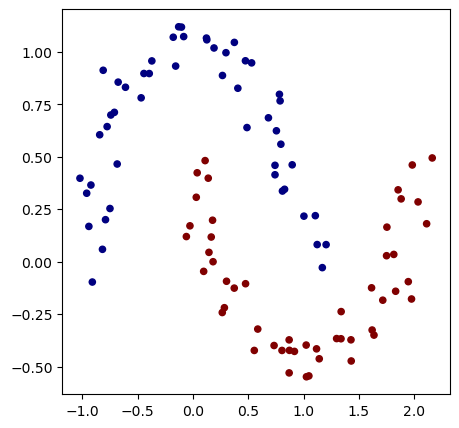

In [13]:
#plot data
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [14]:
#initialize a neural network with 2 inputs (x,y):
model = MLP(2, [16, 16, 1])
print(model)

MLP of [Layer of [tanhNeuron(2), tanhNeuron(2), tanhNeuron(2), tanhNeuron(2), tanhNeuron(2), tanhNeuron(2), tanhNeuron(2), tanhNeuron(2), tanhNeuron(2), tanhNeuron(2), tanhNeuron(2), tanhNeuron(2), tanhNeuron(2), tanhNeuron(2), tanhNeuron(2), tanhNeuron(2)], Layer of [tanhNeuron(16), tanhNeuron(16), tanhNeuron(16), tanhNeuron(16), tanhNeuron(16), tanhNeuron(16), tanhNeuron(16), tanhNeuron(16), tanhNeuron(16), tanhNeuron(16), tanhNeuron(16), tanhNeuron(16), tanhNeuron(16), tanhNeuron(16), tanhNeuron(16), tanhNeuron(16)], Layer of [LinearNeuron(16)]]


In [15]:
#define a loss function:
def loss(batch_size = None):
    
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    #wrap the input as Value objects:
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    #forward propagation, passing in each list in input to the model to get its score
    scores = list(map(model, inputs))

    #here, we implement a max-margin loss. Alternatively, we could use mean-squared error or any other loss function
    losses = [(1 - yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    avg_loss = sum(losses) / len(losses)

    #L2 regularization with alpha * weight^2 to fix overfitting:
    alpha = 1e-4
    reg_loss = alpha * sum(p*p for p in model.parameters())

    total_loss = avg_loss + reg_loss

    #calculate current accuracy:
    accuracy = sum([(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]) / len(scores)

    return total_loss, accuracy

total_loss, accuracy = loss()
print(total_loss, accuracy)

Value(data=1.1815924818239036, grad=0.0) 0.5


In [16]:
#now, we optimize by running the model k times and backpropagating to perform gradient descent:
n = 200
for k in range(n):
    total_loss, accuracy = loss()
    model.zero_grad()
    total_loss.backward()

    #decaying learning rate for stochastic gradient descent:
    alpha = 0.1 - 0.09*k/n
    for p in model.parameters():
        p.data += -(alpha*p.grad)

    print(f"step {k} loss {total_loss.data}, accuracy {accuracy*100}%")

step 0 loss 1.1815924818239036, accuracy 50.0%
step 1 loss 0.5835016661650219, accuracy 73.0%
step 2 loss 0.454381742680817, accuracy 88.0%
step 3 loss 0.3817887149835627, accuracy 86.0%
step 4 loss 0.33998353487538585, accuracy 89.0%
step 5 loss 0.3118539715199589, accuracy 90.0%
step 6 loss 0.29317682231165043, accuracy 90.0%
step 7 loss 0.27906469653467697, accuracy 90.0%
step 8 loss 0.2681174175766649, accuracy 92.0%
step 9 loss 0.25735219614566923, accuracy 92.0%
step 10 loss 0.24801128995673993, accuracy 93.0%
step 11 loss 0.23922792749506006, accuracy 92.0%
step 12 loss 0.23065909479450952, accuracy 93.0%
step 13 loss 0.2227591230153092, accuracy 93.0%
step 14 loss 0.21579170674421153, accuracy 95.0%
step 15 loss 0.2090448385904946, accuracy 94.0%
step 16 loss 0.202539758361827, accuracy 95.0%
step 17 loss 0.19677439542880368, accuracy 95.0%
step 18 loss 0.1919969403893778, accuracy 95.0%
step 19 loss 0.18671172711794115, accuracy 95.0%
step 20 loss 0.18185963687364293, accuracy

(-1.548639298268643, 1.951360701731357)

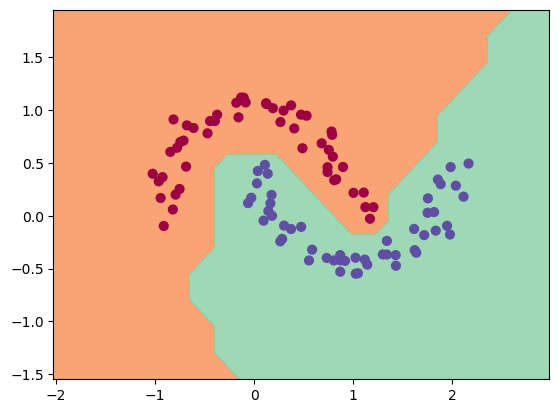

In [17]:
# visualize decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())